# Computing a climatology with `xarray.open_mfdataset`

This notebook demonstrates the use of the `open_mfdataset` function in `xarray` to compute some climatologies. `open_mfdataset` is useful if you have netCDF files broken out along particular dimension, such as the time dimension. It allows you to combine netCDF files along that dimension for processing. 

In [1]:
from pathlib import Path
from dask.distributed import Client
import xarray as xr

Start the local cluster. It would seem that `n_workers=16` works fairly well compared to other values, but this could just be a fluke. If it is real affinity though, probably related to the fact that there are 32 cores and `ThreadsPerCore=2` for the atlas nodes, e.g.:

In [2]:
!scontrol show node atlas03

NodeName=atlas03 Arch=x86_64 CoresPerSocket=8
   CPUAlloc=0 CPUErr=0 CPUTot=32 CPULoad=0.01 Features=(null)
   Gres=(null)
   NodeAddr=192.168.10.63 NodeHostName=atlas03
   OS=Linux RealMemory=1 AllocMem=0 Sockets=2 Boards=1
   State=IDLE ThreadsPerCore=2 TmpDisk=0 Weight=1
   BootTime=2022-07-22T10:22:49 SlurmdStartTime=2022-07-22T10:23:05
   CurrentWatts=0 LowestJoules=0 ConsumedJoules=0
   ExtSensorsJoules=n/s ExtSensorsWatts=0 ExtSensorsTemp=n/s
   



In [3]:
client = Client(dashboard_address="localhost:43368", n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43368/status,
Dashboard: http://127.0.0.1:43368/status,Workers: 16
Total threads: 32,Total memory: 251.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41047,Workers: 16
Dashboard: http://127.0.0.1:43368/status,Total threads: 32
Started: Just now,Total memory: 251.71 GiB
Comm: tcp://127.0.0.1:34250,Total threads: 2
Dashboard: http://127.0.0.1:34335/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:45104,


Open the dataset. The time this takes seems to vary a bit. I have seen this complete in as little as 30s and as long as ~2 minutes. However, not since moving this from Poseidon to `altas_scratch`, so there could just be some networking issue here. We sort of already knew this, but my experience with moving things to scratch space seems to indicate we should always do this when working with large datasets.

In [4]:
%%time
data_dir = "/atlas_scratch/kmredilla/AK_NCAR_12km/met/CCSM4/rcp45/"
ds = xr.open_mfdataset(f"{data_dir}*.nc4", chunks="auto", combine='by_coords')

CPU times: user 16 s, sys: 2.45 s, total: 18.4 s
Wall time: 31.4 s


Compute the historical precipitation climatology:

In [5]:
clim = ds["pcp"].sel(time=slice("1980", "2020")).groupby("time.year").sum(dim="time").mean(dim="year")

In [6]:
%%time
pr_clim = clim.compute()

CPU times: user 2.83 s, sys: 289 ms, total: 3.12 s
Wall time: 5.62 s


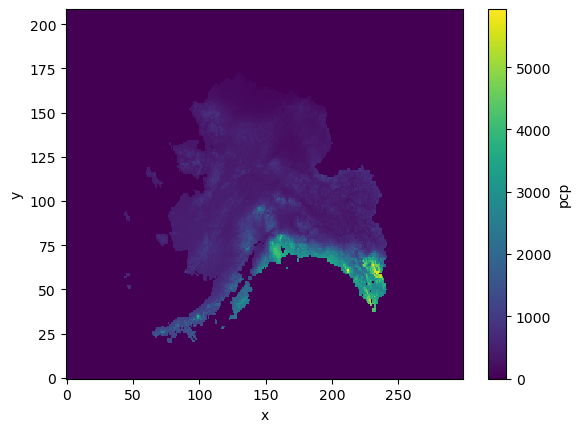

In [7]:
pr_clim.plot()

In [10]:
client.close()

## 20km WRF Utqiagvik temperature point extraction

Here we want to do a point extraction of ERA-Interim air temperature data at Utqiagvik to investigate a question raised by a data user. 

In [1]:
from pathlib import Path
from dask.distributed import Client
import xarray as xr

Start the local cluster

In [2]:
client = Client(dashboard_address="localhost:43368", n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43368/status,
Dashboard: http://127.0.0.1:43368/status,Workers: 16
Total threads: 32,Total memory: 251.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37651,Workers: 16
Dashboard: http://127.0.0.1:43368/status,Total threads: 32
Started: Just now,Total memory: 251.71 GiB
Comm: tcp://127.0.0.1:37553,Total threads: 2
Dashboard: http://127.0.0.1:36150/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:45729,


Open the dataset.

In [3]:
%%time
data_dir = "/rcs/project_data/wrf_data/daily/t2/"
ds = xr.open_mfdataset(f"{data_dir}/t2_daily_wrf_ERA-Interim_historical_*.nc", chunks="auto", combine='by_coords')

CPU times: user 3.78 s, sys: 963 ms, total: 4.74 s
Wall time: 9.87 s


In [6]:
extr_arr = ds["t2"].sel(xc=-166351, yc=-1985598, method="nearest")

In [11]:
%%time
extr_arr.mean().compute() - 273.15

CPU times: user 977 ms, sys: 154 ms, total: 1.13 s
Wall time: 2.64 s


<xarray.DataArray 't2' ()>
array(-10.65701904)
Coordinates:
    xc       float64 -1.7e+05
    yc       float64 -1.982e+06

Okay, this matches expectation for Utqiagvik. This was done using daily data, but we should check using hourly data as well.

In [13]:
%%time
data_dir = "/rcs/project_data/wrf_data/hourly_fix/t2/"
ds = xr.open_mfdataset(
    f"{data_dir}/t2_hourly_wrf_ERA-Interim_historical_*.nc",
    chunks="auto", combine='by_coords'
)

CPU times: user 1.81 s, sys: 496 ms, total: 2.3 s
Wall time: 5.37 s


In [14]:
extr_arr = ds["t2"].sel(xc=-166351, yc=-1985598, method="nearest")

In [15]:
%%time
extr_arr.mean().compute() - 273.15

CPU times: user 9.01 s, sys: 1.49 s, total: 10.5 s
Wall time: 35 s


<xarray.DataArray 't2' ()>
array(-10.65701904)
Coordinates:
    xc       float64 -1.7e+05
    yc       float64 -1.982e+06

In [17]:
client.close()

Verify the coordinates used (pulled from QGIS in exploration). Code copied from WRF point extraction notebook in snap-geo repo:

In [19]:
import xarray as xr
from pyproj import Transformer
from pyproj.crs import CRS
import pandas as pd

lon = -156.7886
lat = 71.2906
coords = (lat, lon)

fp = "/rcs/project_data/wrf_data/daily/pcpt/pcpt_daily_wrf_ERA-Interim_historical_1979.nc"
with xr.open_dataset(fp) as ds:
    # project WGS84 coordinates using proj string from WRF file
    wrf_proj_str = ds.attrs["proj_parameters"]
    
wrf_crs = CRS.from_proj4(wrf_proj_str)
transformer = Transformer.from_crs("epsg:4326", wrf_crs)
transformer.transform(*coords)

(-166336.64907034917, -1985588.1534326067)